# Spectral Type Classification, Filter Curves and Colours with Python

In [66]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from astropy.io import fits
import os
import pandas as pd

ROOT = os.path.dirname(os.path.realpath("__file__"))
PATH = '/Daten/'
BONUS = 'Bonusdaten/'
FILTER = 'Filterkurven/'
REF = 'Referenzspektren/'

Observed spectra, like observed images, are stored in FITS files (https://de.wikipedia.org/wiki/Flexible_Image_Transport_System). The [astropy project provides the FITS module](http://docs.astropy.org/en/stable/io/fits/index.html) for reading and writing FITS files in Python. 

In this exercise we will use the following Python packages:
* Astropy to read in spectra from FITS files 
* Matplotlib to display them on screen. 
* Numpy to manipulate the spectra.

The goal of this exercise is to use the Harvard classification system to determine the spectral type of 13 stars based on the strengths of several well-known absorption lines. We will also use the transmission curves for the B and V filter to derive the "colour" of the stars (optional task).

<div class="alert alert-block alert-info">
    When answering the questions that are not code or plots, try to work with "markdown" (normal text as this one here). We provided you with the cells labelled "<b>Answer</b>". You can "run" these cells with markdown formatting to get non-code text output.
</div>

# Part 1 - Plotting spectra in Python

## 1. The FITS file

All fits files use the ``Header-Data-Unit``, or HDU to store data. This can either be as tables (1D data), images (2D data) or data cubes (3D data). A single FITS files can contain several different HDUs and they can be mixed. For example, a FITS file may contain 4 images and 2 tables, each in separate HDUs. Hence when we open a FITS file, we must also know which HDU to look at to find the data we want.

### Opening
* Choose a file to open
* Use ``fits.open()`` to get a handle to the file

  To access different HDUs, use the ``[n]`` notation after the HDU variable name, where ``n`` is the HDU number we want


* Display the header of primary (i.e. ``[0]``) HDU in the file with the ``.header`` attribute
  
Look at the [astropy FITS module documentation](http://docs.astropy.org/en/stable/io/fits/index.html) if you need help.

If we were to simply ``open()`` the files, we would need to care about closing them again after we are done importing the data. To make our lives easier, we can use Python's ``with`` syntax, which automatically takes care of that. Inside the ``with`` block, we import the data to our internal variables, which we can use from that point on, without having to touch the original file again (unless we need to import from a different file of course).

<div class="alert alert-block alert-success">
    <h4>Task</h4>
    <p>Complete the following code to load the file data into the <tt>header</tt> and <tt>data</tt> variables. You might need to try different HDUs, as escribed above, to get the correct data. Remember you can always use <tt>print(...)</tt> to take a look at what is stored in your variables!</p>
</div>

In [67]:
with fits.open(ROOT+PATH+'1.fits') as file:
    header = file[0].header
    data = file[0].data
print(header)

SIMPLE  =                    T / Fits standard                                  BITPIX  =                  -32 / Bits per pixel                                 NAXIS   =                    1 / Number of axes                                 NAXIS1  =                 4771 / Axis length                                    ORIGIN  = 'NOAO-IRAF FITS Image Kernel July 1999' / FITS file originator        EXTEND  =                    F / File may contain extensions                    DATE    = '2000-02-16T18:15:39' / Date FITS file was generated                  IRAF-TLM= '15:15:39 (16/02/2000)' / Time of last modification                   APNUM1  = '1 1     '                                                            WCSDIM  =                    1                                                  CTYPE1  = 'LINEAR  '                                                            CRVAL1  =                1150.                                                  CRPIX1  =                   1.          

### Axis information

First, we will take a look at the axis information. As you probably know, spectral data usually consists of wavelength on the x-axis and intensities (in various units) on the y-axis. In the data we are using here, there is no wavelength axis available, only information on how to construct it.

In the FITS header, we will usually find some info about the axis present in the file, somewhere close to the top. The first keyword you should be looking for is ``NAXIS``, which tells us the number of axis in the data (e.g. 1 for simple lists, 2 for images or multi-column tables, 3 for datacubes). According to this number, there will be ``n`` more keywords in the style of ``NAXIS1``, ``NAXIS2`` and so on, each telling us the length (=number of data points) on each axis.
We can accessing the values in these header fields via ``header["KEYWORD"]``.

<div class="alert alert-block alert-success">
    <h4>Task</h4>
    <p>Take a look at the values and write a short interpretation of the numbers you see!</p>
</div>

**Answer:**



In [68]:
print("NAXIS:", header["NAXIS"])
print("NAXIS1:", header["NAXIS1"])
print("WCSDIM:", header["WCSDIM"])
print("CTYPE1:", header["CTYPE1"])
print("CRPIX1:", header["CRPIX1"])
print("CRVAL1:", header["CRVAL1"])
print("CDELT1:", header["CDELT1"])

NAXIS: 1
NAXIS1: 4771
WCSDIM: 1
CTYPE1: LINEAR
CRPIX1: 1.0
CRVAL1: 1150.0
CDELT1: 5.0


Next, let's look at the values which actually tell us how to construct our wavelength axis. In our data, this information is stored in the "WCS"-block of the header, which stands for "World Coordinate System". This is more commonly used for defining the coordinate axis of a 2D image, but in our case, it holds the information necessary to convert the position of the data points to wavelengths. The following keywords are useful:
* ``WCSDIM``...number of dimensions/axes of the "coordinate system"
* ``CTYPE1``...type of transformation used on axis 1
* ``CRPIX1``...reference pixel of axis 1, which has the value of:
* ``CRVAL1``...reference value of axis 1, in our case equivalent to the wavelength value of the reference (here = first) pixel $\lambda_0$ in Ångström.
* ``CDELT1``...step size of axis 1, in our case the wavelength intervals, or bin width, $\Delta\lambda$ in Ångström.

<div class="alert alert-block alert-warning">
    <h4>Questions</h4>
    <p>Again display those values from the header and try to answer the following questions with the information you now obtained:</p>
    <ol>
        <li>At what wavelength does the spectrum start?</li>
        <li>How many wavelength "bins" (number of data points) are there in the spectrum?</li>
        <li>What is the step between each bin?</li>
        <li>And using all those values, at what wavelength does the spectrum end?</li>
    </ol>
</div>

**Answer:** 



In [69]:
wavelength_end = header["CRVAL1"]+(header["NAXIS1"]-1)*header["CDELT1"]
print(wavelength_end)

25000.0


### Extract the data

The FITS file (or, to be precise, the HDU) contains the spectrum in the ``data`` property. Accessing this will return a Numpy Array, which can be used directly as your y-data. For the x-data, as stated above we need to construct it first. In the previous section, we obtained all necessary values to do this. What we want is an Array of equally spaced points, starting and ending at the wavelengths you determined above. For this, we can use ``np.arange()``, which is Numpy's Array-version of Python's standard ``range()`` function, which does just that! If you don't know the parameters that go into this function, you can type ``help(np.arange)`` to look it up.

<div class="alert alert-block alert-success">
    <h4>Task</h4>
    <p>We provided you with the beginning, now replace the <tt>...</tt> placeholders below to construct your axes!</p>
</div>

In [70]:
x = np.arange(header["CRVAL1"], wavelength_end + header["CDELT1"], header["CDELT1"])
y = data


You can now check if your two axes have the same length. If they don't, it is not possible to match $x$ and $y$ for each data point. 

In [71]:
print("x:", len(x))
print(f"y: {len(y)}")


x: 4771
y: 4771


## 2. Display the spectrum

### Basics of plotting

The most straightforward way to plot this kind of data is to simply use the matplotlib function ``plt.plot()``. Again, if you aren't familiar with the syntax, use ``help(plt.plot)``. Try it out and have a first look at the spectrum!

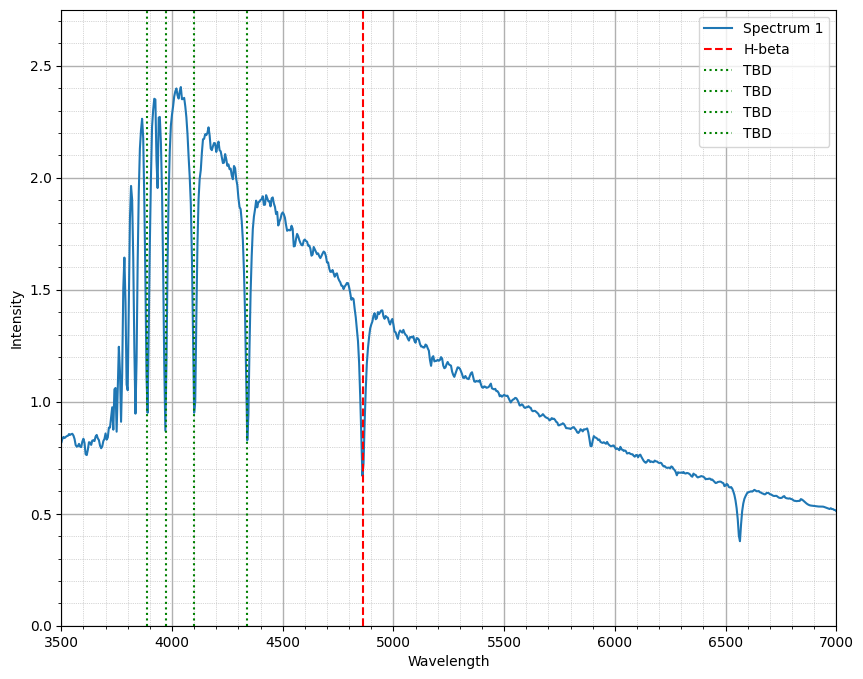

In [72]:
yMin = 0
yMax = 2.75

fig = plt.figure(figsize=(10, 8))
ax = plt.subplot(111)
ax.plot(x, y, label='Spectrum 1')
ax.set_xlabel('Wavelength')
ax.set_ylabel('Intensity')
ax.set_xlim([3500, 7000])
ax.set_ylim([yMin, yMax])

ax.vlines(4861, yMin, yMax, linestyles='dashed', colors='red', label='H-beta')

ax.vlines(4338, yMin, yMax, linestyles=':', colors='green', label='TBD', linewidth=1.5)
ax.vlines(4100, yMin, yMax, linestyles=':', colors='green', label='TBD', linewidth=1.5)
ax.vlines(3971, yMin, yMax, linestyles=':', colors='green', label='TBD', linewidth=1.5)
ax.vlines(3885, yMin, yMax, linestyles=':', colors='green', label='TBD', linewidth=1.5)

plt.legend()
plt.minorticks_on()  
plt.grid(visible=True, which='major', linestyle='-', linewidth=1)
plt.grid(visible=True, which='minor', linestyle=':', linewidth=0.5)
#plt.semilogy()

You can also display different regions of the spectrum by setting the limits of the x-axis using ``plt.xlim()``.

If you want logarithmic axes, use ``plt.semilogy()``, ``plt.semilogx()`` or ``plt.loglog()``.

<div class="alert alert-block alert-warning">
    <h4>Question</h4>
    <p>Discuss the pros and cons of logarithmic plots, both in general and in particular for the spectra we're using. What is the best option in this case and why? Decide for one (plot, semilog or loglog), give a reasoning for your choice and <strong>stick with it for all plots in this exercise for consistency!</strong></p>
</div>

**Answer:**



### Analysing the plot

You are now in a position to start analysing the plotted spectrum. To zoom in on different parts, use ``plt.xlim()`` as discussed before.

<div class="alert alert-block alert-warning">
    <h4>Questions</h4>
    <p>Try to answer the following questions using your plot. You might need to look up wavelengths of prominent absorption lines or use the pdf files provided in Moodle:</p>
    <ol>
        <li>Is the spectrum normalised or not? How can you tell?</li>
        <li>At what wavelength is the peak (highest value) of the spectrum? Note that the data is likely noisy, so try to estimate the actual peak (by eye), don't just take the highest pixel if it doesn't fit.</li>
        <li>At what wavelengths are the strongest absorption features (spectral lines) in this spectrum? Make a list of the wavelengths for the 5 strongest features and note the relative depth of each feature and try to guess the element which might have produced each line! In the "Comments" column, you can add general remarks of the absorption feature.</li>
        <li>What could these elements tell us about the star? Hot/Cold? Young/old? Something else?</li>
        <li>What is happening around 3800 Å (if anything, not every spectrum has that feature (why?))?</li>
    </ol>
</div>

_The relative depth is a measurement of how far an absorption line dips down from the continuum. For example, a line with a minimum very close to the x-axis might have a relative depth close to .9 or 90 %, whereas a line that only goes half the way from the continuum to the bottom will have a relative depth of around .5 or 50 %._

**Answer:**
| Wavelength [Å]  | Absorption Feature   | Element    | Comments |
|-----------------|----------------------|------------|----------|
|                 |                      |            |          |



## 3. Classify the star using the Harvard (-Yerkes) scheme

The next step is to classify the provided spectra using the well-known Harvard (-Yerkes) scheme, i.e. the OBAFGKM spectral classes.

The important lines in this classification scheme are: the Balmer Lines (esp. H beta, delta and epsilon), Calcium H+K doublet, Calcium G line, the Sodium doublet and the Helium lines. Slightly different variants of this scheme exist, we provided you with a rather simple one using less different lines, which you can find as a pdf file on Moodle ("Spektralklassifizierung Flowchart").

In this flowchart, you start at the top left and in each step decide if the spectrum exhibits the characteristics in question. A line counts as "being present" if it is clearly distinguishable from the background noise of the continuum. The meaning of the central lower decision ("Ca H & K <=> H epsilon & delta") is whether the Ca H & K lines (which will usually be about equally strong/deep) are less (<), roughly equal (=) ore more (>) strong/deep than the average of the Balmer lines H epsilon and H delta.

As stated in the flowchart, the "official" distinction between spectral types K and M is not really visibly in our data. There are however other ways to tell these classes apart, try to figure out how! All the borders between spectral classes are of course blurred, so you can use the subclasses denoted with arabic numericals 0-9 to achieve a better classification, or when you think a star seems to be "in between" two classes. Try to give an explanation of how "fine grained" of a subclass is even meaningful to use in the context of this exercise!

<div class="alert alert-block alert-success">
    <h4>Task</h4>
    <p>Plot all of the spectra and classify them by the Harvard (-Yerkes) OBAFGKM scheme. Be sure to include a reasoning for your decisions (i.e. <i>why</i> did you classify star X as class Y). Try to include markers in your plots denoting the lines used in the classification.</p>
</div>

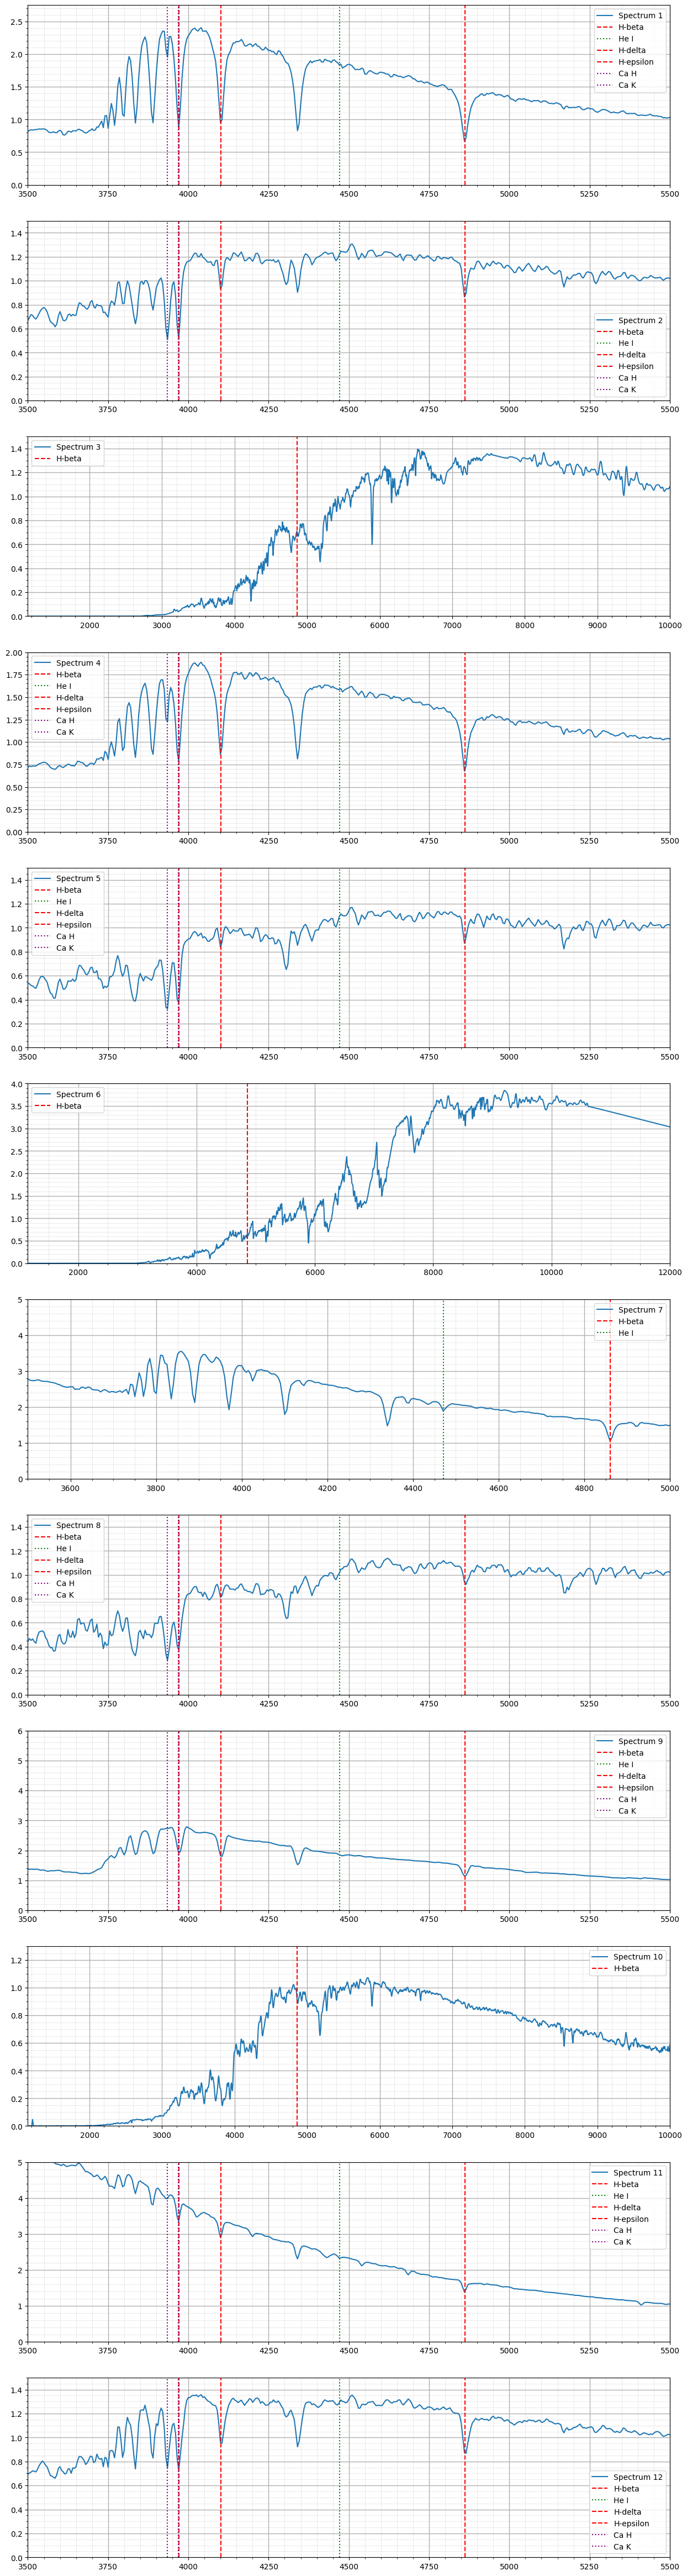

In [73]:
#Calc end of Wave-Band
def calcRangeEnd(head):
    return head["CRVAL1"]+(head["NAXIS1"]-1)*head["CDELT1"]

#calc X Axis
def calcXVals(header):
    return np.arange(header["CRVAL1"], calcRangeEnd(header) + header["CDELT1"], header["CDELT1"])


#Fetch Data-Files
files = [file for file in os.listdir(ROOT+PATH) if file.endswith('fits')]

#Split Filenames for Sorting and def Sorting-Frame
tempArr = []
for file in files:
    nr = file.split('.')[0]
    if file.endswith('fits') == True:
        tempArr.append(int(nr))
    else:
        tempArr.append(None)

#Lookup DF Nr-File
fileFrame = pd.DataFrame({'Nr': tempArr, 'Files': files})
fileFrame.sort_values(['Nr', 'Files'], inplace=True)

#Fetch Data
def openFit(fileName):
    with fits.open(ROOT+PATH+fileName) as fit:
        header = fit[0].header
        data = fit[0].data.flatten()
    return (header, data)

#Extract Header and Data from Files and prep plotable axis
Headers = pd.DataFrame(columns=['Nr', 'Header'])
Spectra = pd.DataFrame(columns=['Nr', 'Data'])
Axes = pd.DataFrame(columns=['X', 'Y'])

for idx, row in fileFrame.iterrows():
    nr = row['Nr']
    file = row['Files']
    fitData = openFit(file)

    Headers.loc[len(Headers)] = [nr, fitData[0]]
    Spectra.loc[len(Spectra)] = [nr, fitData[1]]
    Axes.loc[len(Axes)] = [calcXVals(fitData[0]), fitData[1]]

def plotSpectra(x, y, ax=None, nr=None, xLim=[], yLim=[], emmLines=[]):
    ax.plot(x, y, label=f'Spectrum {nr+1}')
    ax.minorticks_on()  
    ax.grid(visible=True, which='major', linestyle='-', linewidth=1)
    ax.grid(visible=True, which='minor', linestyle=':', linewidth=0.5)

    for line in emmLines:
        match line:
            case 'H-beta':
                ax.vlines(4861, yLim[0], yLim[1], linestyles='dashed', colors='red', label='H-beta')
            case 'He I':
                ax.vlines(4471, yLim[0], yLim[1], linestyles=':', colors='green', label='He I')
            case 'H-delta':
                ax.vlines(4102, yLim[0], yLim[1], linestyles='dashed', colors='red', label='H-delta')
            case 'H-epsilon':
                ax.vlines(3970, yLim[0], yLim[1], linestyles='dashed', colors='red', label='H-epsilon')
            case 'Ca H':
                ax.vlines(3968.5, yLim[0], yLim[1], linestyles=':', colors='purple', label='Ca H')
            case 'Ca K':
                ax.vlines(3933.7, yLim[0], yLim[1], linestyles=':', colors='purple', label='Ca K')

    ax.set_xlim(xLim)
    ax.set_ylim(yLim)
    ax.legend()
    return ax

xScalings = [[3500, 5500]
              ,[3500, 5500]
              ,[1150, 10000]
              ,[3500, 5500]
              ,[3500, 5500]
              ,[1150, 12000]
              ,[3500, 5000]
              ,[3500, 5500]
              ,[3500, 5500]
              ,[1150, 10000]
              ,[3500, 5500]
              ,[3500, 5500]]

yScalings = [[0, 2.75]
             ,[0, 1.5]
             ,[0, 1.5]
             ,[0, 2]
             ,[0, 1.5]
             ,[0, 4]
             ,[0, 5]
             ,[0, 1.5]
             ,[0, 6]
             ,[0, 1.3]
             ,[0, 5]
             ,[0, 1.5]]

emissionLines = [['H-beta', 'He I', 'H-delta', 'H-epsilon', 'Ca H', 'Ca K']
                 ,['H-beta', 'He I', 'H-delta', 'H-epsilon', 'Ca H', 'Ca K']
                 ,['H-beta']
                 ,['H-beta', 'He I', 'H-delta', 'H-epsilon', 'Ca H', 'Ca K']
                 ,['H-beta', 'He I', 'H-delta', 'H-epsilon', 'Ca H', 'Ca K']
                 ,['H-beta']
                 ,['H-beta', 'He I']
                 ,['H-beta', 'He I', 'H-delta', 'H-epsilon', 'Ca H', 'Ca K']
                 ,['H-beta', 'He I', 'H-delta', 'H-epsilon', 'Ca H', 'Ca K']
                 ,['H-beta']
                 ,['H-beta', 'He I', 'H-delta', 'H-epsilon', 'Ca H', 'Ca K']
                 ,['H-beta', 'He I', 'H-delta', 'H-epsilon', 'Ca H', 'Ca K']]


fig, axes = plt.subplots(12, 1, figsize=(15, 60))
for idx, row in Axes.iterrows():
    plotSpectra(row['X'], row['Y'], ax=axes[idx], nr=idx, xLim=xScalings[idx], yLim=yScalings[idx], emmLines=emissionLines[idx])


plt.show()


<div class="alert alert-block alert-warning">
    <h4>Further theoretical Questions</h4>
    <p>Why do strong Balmer lines mean we are looking at hotter stars? What could be happening in the stars' atmosphere to cause the Calcium H+K and Calcium G lines to be strongest in solar type (F, G) stars?</p>
</div>

**Answer:**



## 4. Luminosity class

If all stars were main sequence stars, the Harvard system would be enough to get a rough idea of what type of star we are looking at. However, stars change as they age. They evolve from main sequence stars to giant stars and thus their luminosity increases. Therefore, an extension to the classification system is used, the luminosity class, denoted with roman numericals. One way to determine whether a star is a main sequence (luminosity class V) or a giant (class I to III) is to look at its spectrum. We provided you with two additional spectra, which only differ in luminosity class (V and I), but have the same spectral class (A0).

<div class="alert alert-block alert-success">
    <h4>Task</h4>
    <p>Open the following two files and plot their spectra in a single plot:</p>
    <ul>
        <li><tt>a0v.fits</tt></li>
        <li><tt>a0i.fits</tt></li>
    </ul>
</div>

(0.0, 3.0)

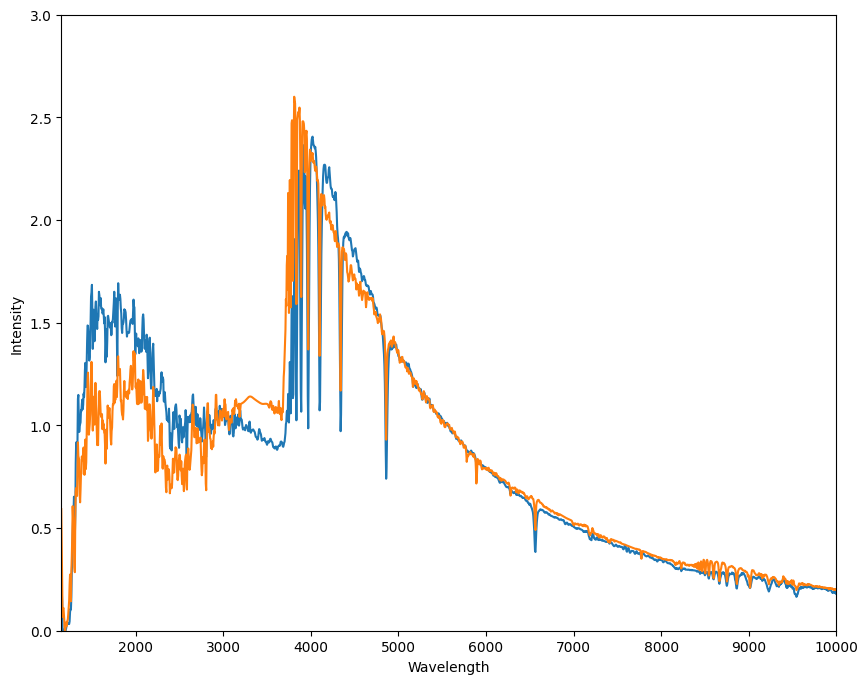

In [74]:
with fits.open(ROOT+PATH+REF+'a0i.fits') as file:
    header_a0i = file[0].header
    data_a0i = file[0].data

x_a0i = np.arange(header_a0i["CRVAL1"], calcRangeEnd(header_a0i) + header_a0i["CDELT1"], header_a0i["CDELT1"])
y_a0i = data_a0i

with fits.open(ROOT+PATH+REF+'a0v.fits') as file:
    header_a0v = file[0].header
    data_a0v = file[0].data

x_a0v = np.arange(header_a0v["CRVAL1"], calcRangeEnd(header_a0v) + header_a0v["CDELT1"], header_a0v["CDELT1"])
y_a0v = data_a0v

fig = plt.figure(figsize=(10, 8))
ax = plt.subplot(111)
ax.plot(x_a0v, y_a0v, label='Spectrum A0V')
ax.plot(x_a0i, y_a0i, label='Spectrum A0I')
ax.set_xlabel('Wavelength')
ax.set_ylabel('Intensity')
ax.set_xlim([1150, 10000])
ax.set_ylim([0, 3])




<div class="alert alert-block alert-warning">
    <h4>Questions</h4>
    <p>What differences do you note between the spectra? What is the difference between the two stars, based on their classification (A0V and A0I)? Which of the following parameters are different, which are (roughly) the same and why: temperature, age, radius, mass, luminosity?</p>
</div>

**Answer:**



<div class="alert alert-block alert-success">
    <h4>Task</h4>
    <p>Using the information from those two spectra (i.e. their differences), try to classify the previous spectra in terms of their luminosity classes. Now because we only have the example spectra for A-type stars here, it is sufficient to do this only for those stars which you previously classified as B, A or F. Any other spectral type is too different altogehter to allow any meaningful determination of luminosity class based on an A0I/A0V example.</p>
</div>

## 5. Spectrophotometry

To get a rough estimation of a star's colour, we can look at the flux of the spectrum in certain wavelength bands, which correspond to photometric filters. Since these filters are not perfect rectangles, but have a transmission curve, we provided you with approximate values for transmission at certain wavelength intervals for three of the most important filters, B, V and R.

<div class="alert alert-block alert-success">
    <h4>Task</h4>
    <p>You can use these filter curves to obtain the total (integrated) flux in the three filters for each star. By comparing the B, V and R values, you can calculate a "colour" for the star. Because the wavelength axis of the filter files is not the same as that of the spectra, you'll need to perform an interpolation of the filter curves using e.g. an appropriate numpy function.</p>
</div>

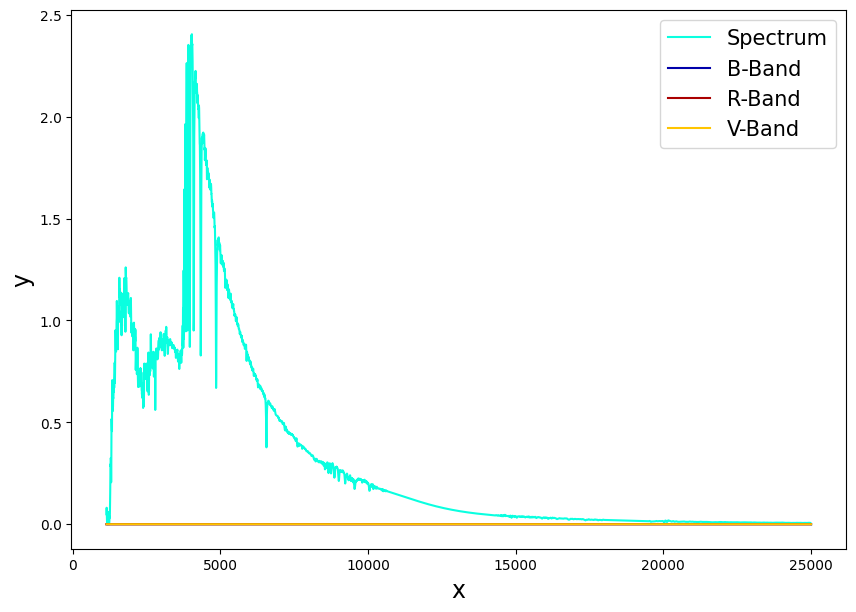

In [77]:
filters = ['filter_B.txt', 'filter_R.txt', 'filter_V.txt']

data = []
for file in filters:
    data.append(np.genfromtxt(ROOT+PATH+FILTER+file, dtype=np.float32, names = ['Wavelength','Throughput'], usecols=(0, 1)))

filterWavelengthsB = []
filterValuesB = []
for f in data[0]:
    filterWavelengthsB.append(f[0])
    filterValuesB.append(f[1])

filterWavelengthsR = []
filterValuesR = []
for f in data[1]:
    filterWavelengthsR.append(f[0])
    filterValuesR.append(f[1])

filterWavelengthsV = []
filterValuesV = []
for f in data[2]:
    filterWavelengthsV.append(f[0])
    filterValuesV.append(f[1])

x_int = np.arange(x.min(), x.max() ,0.001)

def linInterp(xData, yData):
    yi = np.array(yData)[np.digitize(xData, x)]
    y_int = np.interp(x_int, xData, yi)
    return (y_int)

fig, ax = plt.subplots(1, 1, figsize=(10,7))
ax.plot(x, y, c='#0AFFE0', label='Spectrum')  
ax.plot(x_int, linInterp(filterWavelengthsB, filterValuesB), c='#0000AA', label='B-Band')
ax.plot(x_int, linInterp(filterWavelengthsR, filterValuesR), c='#AA0000', label='R-Band')  
ax.plot(x_int, linInterp(filterWavelengthsV, filterValuesV), c='#FFC500', label='V-Band')  
ax.set_xlabel('x', fontsize=17)
ax.set_ylabel('y', fontsize=17)
ax.legend(loc='best', fontsize=15)

